In [17]:
import tensorflow as tf
import numpy as np
import cv2
import os

In [18]:
def get_data_list(path="车牌字符识别训练数据"):
    fi = []
    rt = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f != '车牌字符识别训练数据' and f != '.DS_Store':
                # 路徑：os.path.join(root, f)
                im = cv2.resize(cv2.imread(os.path.join(root, f)), (24, 48), interpolation=cv2.INTER_CUBIC)
                fi.append(im)
                rt.append(root.split('/')[-1])
                # print(cv2.imread(os.path.join(root, f)))
                # new = fname[0] + 'b' + fname[1]
                # os.rename(os.path.join(rt, f), os.path.join(rt, new))
    print(len(fi))
    return fi, rt


In [23]:
def write_tfrecords(file_name, data_labels, data_datas):
    writer = tf.python_io.TFRecordWriter(file_name + ".tfrecords")
    num = len(data_labels)
    for i in range(num):
        if (i + 1) % 1000 == 0:
            print("以處理{0}數據集{1}張".format(file_name, i + 1))
        label = data_labels[i].encode()
        data = np.resize(data_datas[i], [1, 3456])[0].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            "label": tf.train.Feature(bytes_list=tf.train.BytesList(value=[label])),
            'img_val': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data]))
        }))  # example對象 對label及img_val 進行封裝
        writer.write(example.SerializeToString())
        i += 1
    print("{0}數據集處理完成".format(file_name))
    writer.close()

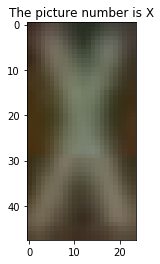

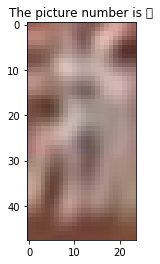

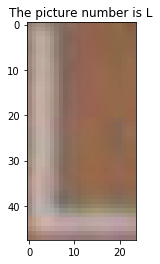

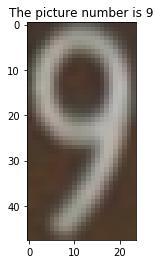

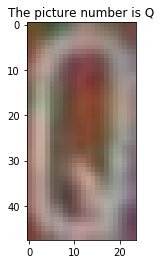

In [43]:
def print_tfrecord():
    # 將製作好的 tfrecord 數據集文件讀取出來,並轉換成圖片,以驗證數據是否準確無誤
    from PIL import Image

    filename_queue = tf.train.string_input_producer(["train.tfrecords"])  # 讀入數據流
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)  # 返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.string),
                                           'img_val': tf.FixedLenFeature([], tf.string),
                                       })  # 取出包含image和label的feature对象
    image = tf.decode_raw(features['img_val'], tf.uint8)
    label = tf.cast(features['label'], tf.string)

    import matplotlib.pyplot as plt
    % matplotlib inline

    with tf.Session() as sess:  # 開始一個對話
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(5):
            example, l = sess.run([image, label])  # 在會話中取出image和label數據
            img=np.resize(example, [48, 24, 3])
            plt.title("The picture number is " + str(l.decode('utf-8')))
#             plt.figure(figsize=(2,4))
            plt.imshow(img)
            plt.show()
        coord.request_stop()
        coord.join(threads)
        
print_tfrecord()

In [21]:
def turn_two_color(name):
    img = cv2.imread(name)
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    a = 0
    for i in grayImage:
        b = 0
        for j in i:
            if j < grayImage.mean():  # 比对均值
                grayImage[a][b] = 0
            else:
                grayImage[a][b] = 255
            b += 1
        a += 1
        del b
    cv2.imwrite(name, grayImage)

In [25]:
from random import shuffle
filedata, filelabel = get_data_list('车牌字符识别训练数据')
x = [i for i in range(len(filelabel))] # 18499
shuffle(x)
a=[];b=[]
for i in x[:13000]:
    a.append(filelabel[i])
    b.append(filedata[i])
write_tfrecords('train',a,b)
a=[];b=[]
for i in x[13000:16400]:
    a.append(filelabel[i])
    b.append(filedata[i])
write_tfrecords('validation',a,b)
a=[];b=[]
for i in x[16400:]:
    a.append(filelabel[i])
    b.append(filedata[i])
write_tfrecords('test',a,b)

18449
以處理train數據集10000張
train數據集處理完成
validation數據集處理完成
test數據集處理完成
